In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the sims_maf modules needed.

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

'MetricBundles' combine a particular metric, a slicer, and a sqlconstraint. You can also add additional provenance/metadata information to a given benchmark, in the form of the (opsim) runName and a metadata comment. This information will be used to generate outfile filenames and plot labels. A given metricbundle will also store the metric values calculated at each point of the slicer (after this is generated via the 'MetricBundleGroup' methods). 

To instantiate a MetricBundle, first instantiate a metric and slicer, then the MetricBundle to store the combination. Here we'll calculate the minimum airmass value, at each point in a healpix grid.

In [4]:
metric1 = metrics.MinMetric('airmass')
slicer1 = slicers.HealpixSlicer(nside=64)
sqlconstraint= 'filter = "r"' 
minairmass = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Here is another example of a MetricBundle, this time reusing the same slicer, but changing the metric - this time we'll count the number of visits at each point in the healpix grid.

In [6]:
metric2 = metrics.CountMetric('expMJD')
nvisits = metricBundles.MetricBundle(metric2, slicer1, sqlconstraint)

We can also add "summary metrics" - metrics that will generate statistical summaries of the metric data values -- and add these to the MetricBundle to run later.

In [7]:
summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(), metrics.MaxMetric(), metrics.RmsMetric()]
minairmass.setSummaryMetrics(summaryMetrics)
nvisits.setSummaryMetrics(summaryMetrics)

And here is yet another example, where we'll use a different slicer, but the same metrics as above, and add the summaryMetrics directly into the construction of the MetricBundle.

In [8]:
slicer2 = slicers.OneDSlicer(sliceColName='night', binsize=1, binMin=0, binMax=365*10)
nvisitsPerNight = metricBundles.MetricBundle(metric1, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)
minairmassPerNight = metricBundles.MetricBundle(metric2, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)

We group MetricBundles with the same sql constraint together into a dictionary, which will be passed to the MetricBundleGroup to run the MetricBundles, calculating the metric values.

In [9]:
bDict = {'min airmass':minairmass, 'nvisits':nvisits, 
         'nvisitsNightly':nvisitsPerNight, 'minairmassPerNight':minairmassPerNight}

Now we set up our connections to the opsim database, and a 'results database' where we will store information about the metricbundles which were run.

In [10]:
opsdb = db.OpsimDatabase('sqlite:///enigma_1189_sqlite.db')
outDir = 'test'
resultsDb = db.ResultsDb(outDir=outDir)

Ready to do some calculating! Instantiate the MetricBundleGroup by passing it the dictionary of MetricBundles we want to run (they must have the same sql constraint), the opsim database object, the output directory and the results database object.

In [11]:
bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)

Now you can query the data from the opsim database and calculate the metric values. Note that MAF determines what columns you need from the database for your metrics and slicers, and only queries for those. MAF calculates the metrics in an efficient manner, caching results where possible and iterating through each slicer only once for all related metrics.

In [12]:
bgroup.runAll()

Querying database with constraint filter = "r"
Found 544710 visits
Running:  ['nvisitsNightly', 'minairmassPerNight']
Completed
Running:  ['min airmass', 'nvisits']
Completed


The results of the metric calculation are stored as an attribute in each metricbundle, as 'metricValues' - a numpy masked array.

In [13]:
print nvisits.metricValues

[-- -- -- ..., 30.0 30.0 60.0]


We can save the MetricBundle results to disk. Each MetricBundle has a method called 'write' that writes to disk; using 'writeAll' on the MetricBundleGroup just writes all metricBundles to disk at once as a convenience.

In [15]:
bgroup.writeAll()

In [16]:
!ls $outDir

opsim_Count_expMJD_r_HEAL.npz opsim_Count_expMJD_r_ONED.npz opsim_Min_airmass_r_HEAL.npz  opsim_Min_airmass_r_ONED.npz  resultsDb_sqlite.db


And we can generate plots (which are also saved to disk by default). Again, the MetricBundleGroup has a method called 'plotAll' which will generate all plots for all MetricBundles, but we can call 'plot' on the individual MetricBundles to generate plots just for that combination. 

Optimal bin calculation tried to make 655 bins, returning 200


{'Histogram': 1, 'PowerSpectrum': 3, 'SkyMap': 2}

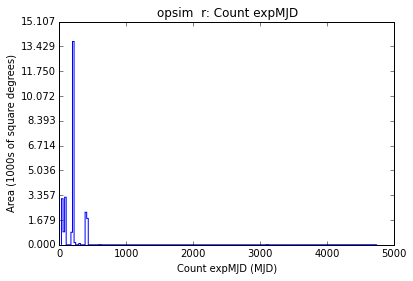

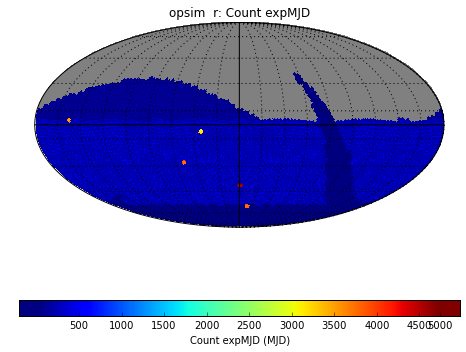

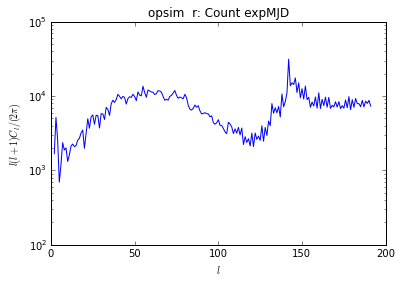

In [17]:
nvisits.plot()

We can edit the plotting parameters, by setting values in the plotDict associated with each benchmark. 

In [18]:
nvisits.plotDict

{'cbarFormat': '%d',
 'title': 'opsim  r: Count expMJD',
 'units': 'MJD',
 'xlabel': 'Count expMJD (MJD)'}

In [19]:
newPlotParams = {'xMin':0, 'xMax':300, 'colorMin':0, 'colorMax':300, 'xlabel':'Nvisits'}
nvisits.setPlotDict(newPlotParams)

In [20]:
nvisits.plotDict

{'cbarFormat': '%d',
 'colorMax': 300,
 'colorMin': 0,
 'title': 'opsim  r: Count expMJD',
 'units': 'MJD',
 'xMax': 300,
 'xMin': 0,
 'xlabel': 'Nvisits'}

And replot. (here we'll just replot the skymap).

{'SkyMap': 1}

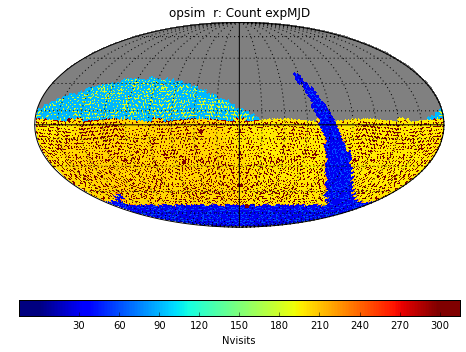

In [22]:
nvisits.plot(plotFunc='plotSkyMap')

Finally, we can calculate summary statistics on a given MetricBundle, using the metricBundle method 'computeSummaryStats' (or all MetricBundles in a MetricBundleGroup using the 'summaryAll' method on MetricBundleGroup). The results of these summary statistics are stored in each MetricBundle, in an attribute called 'summaryValues', and also written to disk in the resultsDb sqlite file.

In [23]:
bgroup.summaryAll()

In [24]:
nvisits.summaryValues

[['Min', 30.0],
 ['Median', 200.0],
 ['Max', 4739.0],
 ['Rms', 192.03189557237977]]